# Cuaderno 03: Vía Visual - Mapeo de Grafema a Embedding Auditivo

### Objetivo 🎯
Este cuaderno es el núcleo de la hipótesis del proyecto. Su objetivo es entrenar una **Vía Visual** capaz de "imaginar" o predecir la representación neuronal de un sonido (un *embedding* de `wav2vec2`) a partir de la simple imagen de su letra (grafema).

Emulamos así el proceso cognitivo de la **conciencia fonológica**: la habilidad de asociar un símbolo visual con su correspondiente unidad de sonido.

### Flujo de Trabajo ⚙️
1.  **Configuración**: Instalaremos `cornet` y definiremos los parámetros globales del experimento.
2.  **Pre-procesamiento de Imágenes**: Redimensionaremos las imágenes de grafemas a 64x64 para acelerar drásticamente el entrenamiento.
3.  **Definición de Arquitecturas**: Se definirán las clases `Dataset` y los modelos `PhonemeCNN` (experto congelado) y `VisualToAuditoryModel` (CORNet-Z + Decodificador LSTM).
4.  **Entrenamiento con Pérdida Perceptual**: Entrenaremos la vía visual utilizando el clasificador auditivo congelado como una función de pérdida para guiar el aprendizaje.
5.  **Análisis Cualitativo (t-SNE)**: Se generará un gráfico t-SNE que visualiza los embeddings de audio reales y los predichos por la vía visual, **resaltando los errores de clasificación** para un análisis cualitativo.
6.  **Evaluación Cuantitativa**: Se medirán métricas de clasificación (Accuracy, F1, etc.) y se visualizarán matrices de confusión y heatmaps para validar el éxito del mapeo de forma cuantitativa.
7.  **Guardado de Artefactos**: Se guardarán los modelos, figuras y tablas de métricas.

## Paso 1: Configuración e Instalación

Instalamos las dependencias, importamos los módulos necesarios y definimos los parámetros y rutas que se usarán en todo el cuaderno.

In [1]:
%pip install cornet scikit-learn seaborn pandas matplotlib adjustText --quiet

# Librerías estándar y de manejo de datos
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm.auto import tqdm
import os
from collections import OrderedDict
import warnings

# PyTorch, Torchvision y CORNet
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torch.nn.utils.rnn import pad_sequence
import torchvision.transforms as transforms
from PIL import Image
from cornet.cornet_z import CORnet_Z

# Métricas y Visualización
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_recall_fscore_support
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
from adjustText import adjust_text # <--- AÑADIR ESTA LÍNEA

# --- Parámetros Globales del Experimento ---
LANGUAGES = ['es', 'en']
MODEL_ARCHITECTURE = "visual_cornetZ_lstm_perceptual"
EPOCHS = 100
BATCH_SIZE = 128
LEARNING_RATE = 0.001
VALIDATION_SPLIT = 0.2
IMAGE_SIZE = 64 # Imágenes de 64x64
RANDOM_SEED = 42

# --- Rutas del Proyecto ---
project_root = Path.cwd().parent
model_dir = project_root / "results/trained_models"
figure_dir = project_root / "results/figures"
results_dir = project_root / "results/tables"

# Crear directorios si no existen
model_dir.mkdir(parents=True, exist_ok=True)
figure_dir.mkdir(parents=True, exist_ok=True)
results_dir.mkdir(parents=True, exist_ok=True)

# --- Diccionarios para almacenar resultados ---
results_visual = {}
evaluation_metrics = []

Note: you may need to restart the kernel to use updated packages.


## Paso 2: Pre-procesamiento de Imágenes (Tarea Única)

Para acelerar el entrenamiento, realizamos el redimensionado de las imágenes una sola vez. Esta celda lee las imágenes originales, las ajusta a 64x64 píxeles y las guarda en una nueva carpeta. El bucle de entrenamiento leerá directamente de esta carpeta optimizada.

In [2]:
print("Iniciando el pre-procesamiento de imágenes...")
resize_transform = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE))])

for lang in LANGUAGES:
    source_image_dir = project_root / f"data/02_processed/grapheme_images/{lang}"
    target_image_dir = project_root / f"data/02_processed/grapheme_images_resized_{IMAGE_SIZE}/{lang}"
    
    grapheme_folders = [d for d in source_image_dir.iterdir() if d.is_dir()]
    print(f"Procesando {len(grapheme_folders)} grafemas para '{lang.upper()}'...")
    
    for grapheme_dir in tqdm(grapheme_folders, desc=f'Procesando {lang.upper()}'):
        target_grapheme_path = target_image_dir / grapheme_dir.name
        target_grapheme_path.mkdir(parents=True, exist_ok=True)
        
        for img_path in grapheme_dir.glob("*.png"):
            if not (target_grapheme_path / img_path.name).exists():
                image = Image.open(img_path).convert("RGB")
                resized_image = resize_transform(image)
                resized_image.save(target_grapheme_path / img_path.name)
            
print(f"\nPre-procesamiento completado. Las imágenes de {IMAGE_SIZE}x{IMAGE_SIZE} están listas.")

Iniciando el pre-procesamiento de imágenes...
Procesando 25 grafemas para 'ES'...


Procesando ES:   0%|          | 0/25 [00:00<?, ?it/s]

Procesando 25 grafemas para 'EN'...


Procesando EN:   0%|          | 0/25 [00:00<?, ?it/s]


Pre-procesamiento completado. Las imágenes de 64x64 están listas.


## Paso 3: Data Loading y Arquitecturas de Modelos

Aquí se definen todas las clases necesarias para el experimento.

* **`GraphemeDataset`**: Carga pares de imagen-embedding, asegurando que solo se usen los grafemas comunes a ambos dominios.
* **`PhonemeCNN`**: La arquitectura idéntica a la del clasificador auditivo entrenado en el cuaderno 02. Lo usaremos como "experto" congelado.
* **`VisualToAuditoryModel`**: El modelo principal. Utiliza una red **CORNet-Z** pre-entrenada para extraer características visuales y un **Decodificador LSTM** para generar la secuencia de embeddings auditivos.

In [3]:
class GraphemeDataset(Dataset):
    """Carga pares de (imagen de grafema, secuencia de embedding auditivo)."""
    def __init__(self, image_dir, embedding_dir, transform=None):
        self.transform = transform
        image_graphemes = {p.parent.name for p in image_dir.glob("*/*.png")}
        embedding_graphemes = {p.stem for p in embedding_dir.glob("*.npy")}
        
        common_graphemes = sorted(list(image_graphemes.intersection(embedding_graphemes)))
        self.labels = [g for g in common_graphemes if len(g) == 1]
        
        self.image_paths = []
        self.embedding_paths = {}
        for grapheme in self.labels:
            self.image_paths.extend(list((image_dir / grapheme).glob("*.png")))
            self.embedding_paths[grapheme] = embedding_dir / f"{grapheme}.npy"
        
        print(f"Dataset creado con {len(self.image_paths)} imágenes de {len(self.labels)} grafemas comunes.")
        
    def __len__(self): return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = img_path.parent.name
        image = Image.open(img_path).convert("RGB")
        if self.transform: image = self.transform(image)
        
        embedding = torch.tensor(np.load(self.embedding_paths[label]), dtype=torch.float32)
        return image, embedding, label

class PhonemeCNN(nn.Module):
    """Arquitectura del clasificador auditivo (debe ser idéntica a la del cuaderno 02)."""
    def __init__(self, input_size=1024, num_classes=27, dropout=0.5):
        super().__init__()
        self.conv_block1 = nn.Sequential(nn.Conv1d(input_size, 128, 3, 1), nn.BatchNorm1d(128), nn.ReLU())
        self.conv_block2 = nn.Sequential(nn.Conv1d(128, 256, 3, 1), nn.BatchNorm1d(256), nn.ReLU())
        self.pool = nn.AdaptiveMaxPool1d(1)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(256, num_classes)

    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.pool(x).view(x.size(0), -1)
        x = self.dropout(x)
        return self.fc(x)

class VisualToAuditoryModel(nn.Module):
    """Modelo híbrido que mapea una imagen a una secuencia de embeddings."""
    def __init__(self, target_embedding_dim=1024, lstm_hidden_dim=512, dropout=0.3):
        super().__init__()
        self.cornet = CORnet_Z()
        url = 'https://s3.amazonaws.com/cornet-models/cornet_z-5c427c9c.pth'
        ckpt_data = torch.hub.load_state_dict_from_url(url, map_location="cpu")['state_dict']
        self.cornet.load_state_dict(OrderedDict((k.replace("module.", ""), v) for k, v in ckpt_data.items()))
        
        cornet_output_dim = self.cornet.decoder.linear.in_features
        self.cornet.decoder.linear = nn.Identity()
        for param in self.cornet.parameters(): param.requires_grad = False
        
        self.projector = nn.Sequential(nn.Linear(cornet_output_dim, lstm_hidden_dim), nn.BatchNorm1d(lstm_hidden_dim), nn.ReLU(), nn.Dropout(dropout))
        self.decoder_lstm = nn.LSTM(lstm_hidden_dim, lstm_hidden_dim, num_layers=2, batch_first=True, dropout=dropout)
        self.output_layer = nn.Linear(lstm_hidden_dim, target_embedding_dim)

    def forward(self, image, target_sequence):
        seq_len = target_sequence.shape[1]
        h0 = self.projector(self.cornet(image)).unsqueeze(0).repeat(2, 1, 1)
        c0 = torch.zeros_like(h0)
        decoder_input = h0[-1].unsqueeze(1).repeat(1, seq_len, 1)
        lstm_output, _ = self.decoder_lstm(decoder_input, (h0, c0))
        return self.output_layer(lstm_output)

def collate_fn_visual(batch):
    """Collate function para el dataloader de la vía visual."""
    images = torch.stack([item[0] for item in batch])
    embeddings = [item[1] for item in batch]
    labels = [item[2] for item in batch]
    padded_embeddings = pad_sequence(embeddings, batch_first=True, padding_value=0.0)
    return images, padded_embeddings, labels

## Paso 4: Entrenamiento con Pérdida Perceptual

Este es el paso más importante. En lugar de usar una pérdida simple como el Error Cuadrático Medio (MSE) directamente sobre los embeddings, empleamos una **Pérdida Perceptual**.

**¿Cómo funciona?**

1.  Cargamos nuestro clasificador auditivo (`PhonemeCNN`) y **congelamos sus pesos**. Este modelo actúa como un "experto" que sabe qué características de un embedding son importantes para identificar un fonema.
2.  Durante el entrenamiento, pasamos tanto los embeddings **reales** (target) como los **predichos** (generados por la vía visual) a este clasificador experto.
3.  Calculamos la pérdida (MSE) no sobre los embeddings, sino sobre **las salidas del clasificador (logits)**.

El objetivo del entrenamiento se convierte en: "crea un embedding que el experto identifique de la misma manera que el real". Esto alinea el entrenamiento de la vía visual con el objetivo final de la clasificación fonológica, produciendo resultados mucho más robustos.

In [4]:
transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
perceptual_loss_fn = nn.MSELoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(RANDOM_SEED)

for lang in LANGUAGES:
    print(f"\n{'='*20} PROCESANDO IDIOMA: {lang.upper()} {'='*20}")
    
    image_dir = project_root / f"data/02_processed/grapheme_images_resized_{IMAGE_SIZE}/{lang}"
    embedding_dir = project_root / f"data/02_processed/wav2vec2_embeddings/{lang}"
    auditory_model_path = model_dir / f"{lang}_auditory_cnn1d_comparative.pth"
    
    if not auditory_model_path.exists():
        print(f"Modelo auditivo para '{lang}' no encontrado. Saltando...")
        continue
    
    auditory_cnn = PhonemeCNN(num_classes=len(list(embedding_dir.glob("*.npy")))).to(device)
    auditory_cnn.load_state_dict(torch.load(auditory_model_path, map_location=device))
    auditory_cnn.eval()
    for param in auditory_cnn.parameters(): param.requires_grad = False
    
    full_dataset = GraphemeDataset(image_dir, embedding_dir, transform=transform_train)
    val_size = int(VALIDATION_SPLIT * len(full_dataset))
    train_size = len(full_dataset) - val_size
    train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn_visual, num_workers=2, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn_visual, num_workers=2, pin_memory=True)

    model = VisualToAuditoryModel().to(device)
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    history = {'train_loss': [], 'val_loss': [], 'val_euclidean_dist': []}

    print(f"Entrenando modelo para '{lang}' con {len(train_dataset)} imágenes...")
    for epoch in tqdm(range(EPOCHS), desc=f'Training {lang.upper()}'):
        model.train()
        running_loss = 0.0
        for images, targets, _ in train_loader:
            images, targets = images.to(device), targets.to(device)
            optimizer.zero_grad()
            
            predictions = model(images, targets)
            loss = perceptual_loss_fn(auditory_cnn(predictions), auditory_cnn(targets))
            
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        history['train_loss'].append(running_loss / len(train_loader))

        model.eval()
        val_loss, val_dist = 0.0, 0.0
        with torch.no_grad():
            for images, targets, _ in val_loader:
                images, targets = images.to(device), targets.to(device)
                predictions = model(images, targets)
                val_loss += perceptual_loss_fn(auditory_cnn(predictions), auditory_cnn(targets)).item()
                val_dist += F.pairwise_distance(predictions.mean(dim=1), targets.mean(dim=1)).mean().item()
        
        history['val_loss'].append(val_loss / len(val_loader))
        history['val_euclidean_dist'].append(val_dist / len(val_loader))
    
    print(f"Epoch [{EPOCHS}], Train Loss: {history['train_loss'][-1]:.4f}, Val Loss: {history['val_loss'][-1]:.4f}, Val Euclidean Dist: {history['val_euclidean_dist'][-1]:.4f}")
    results_visual[lang] = {'history': history, 'model': model}


==================== PROCESANDO IDIOMA: ES ====================
Dataset creado con 1250 imágenes de 25 grafemas comunes.
Entrenando modelo para 'es' con 1000 imágenes...


Training ES:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [100], Train Loss: 0.3706, Val Loss: 6.1268, Val Euclidean Dist: 8.4056

==================== PROCESANDO IDIOMA: EN ====================
Dataset creado con 1250 imágenes de 25 grafemas comunes.
Entrenando modelo para 'en' con 1000 imágenes...


Training EN:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [100], Train Loss: 0.7705, Val Loss: 3.6033, Val Euclidean Dist: 7.8223


## Paso 5: Análisis Cualitativo del Mapeo (t-SNE)

Esta sección se centra en una visualización t-SNE avanzada para entender cualitativamente cómo la vía visual mapea los grafemas a los embeddings auditivos.

El gráfico mostrará:
* **Color**: Diferencia entre idiomas (azul para ES, naranja para EN).
* **Marcador**: Distingue si el embedding proviene de la **ruta auditiva real** (círculos `o`) o es una **predicción de la ruta visual** (cruces `X`).
* **Etiquetas**: Se etiquetan los puntos correspondientes a los embeddings de **Audio Real** con su grafema, y las **predicciones incorrectas** de la vía visual se resaltan con una etiqueta roja indicando el error (ej. "a → c").
* **Transparencia y Tamaño**: Ajustes para una mejor visibilidad de los puntos superpuestos y el resaltado de errores.

Esto nos permite observar la formación de clusters por grafema e idioma, y, crucialmente, identificar dónde y cómo la vía visual comete errores en su "interpretación" fonológica.

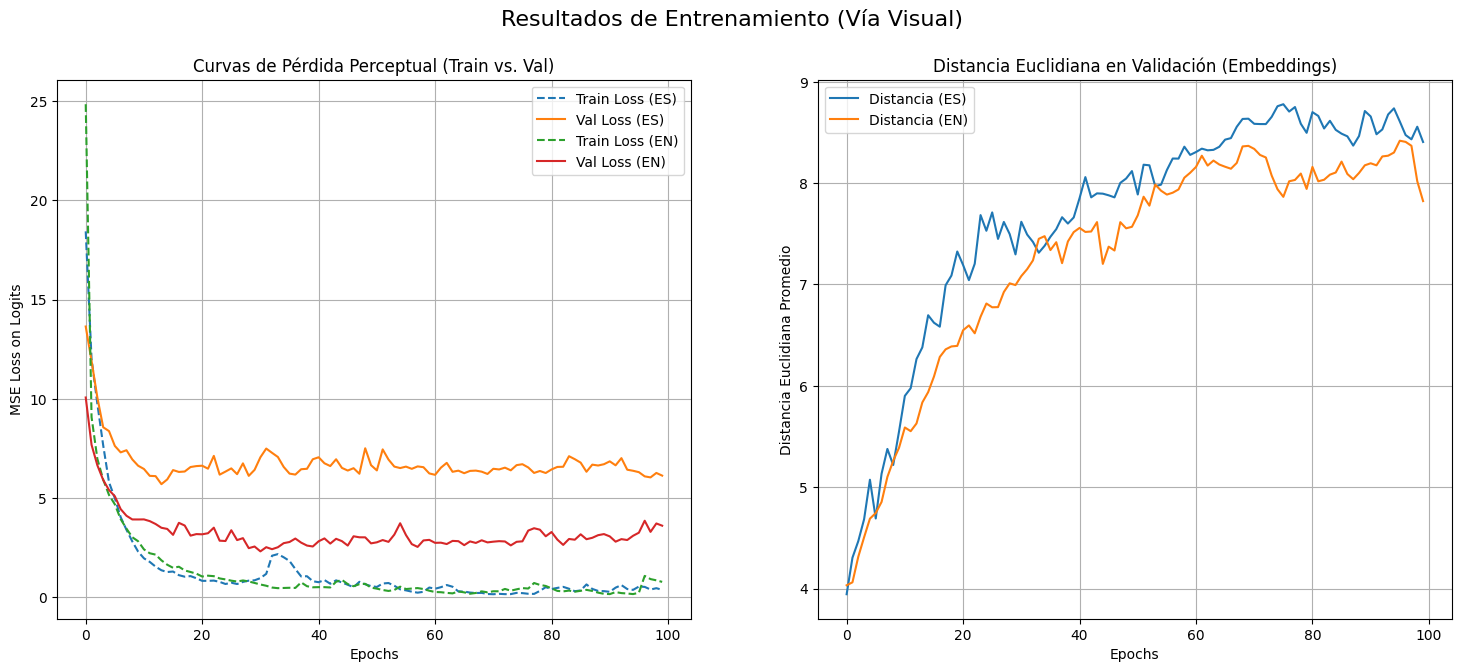

In [5]:
# --- 5.1 Curvas de Aprendizaje Comparativas ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))

for lang in LANGUAGES:
    if lang in results_visual:
        ax1.plot(results_visual[lang]['history']['train_loss'], label=f'Train Loss ({lang.upper()})', linestyle='--')
        ax1.plot(results_visual[lang]['history']['val_loss'], label=f'Val Loss ({lang.upper()})')
ax1.set_title('Curvas de Pérdida Perceptual (Train vs. Val)')
ax1.set_xlabel('Epochs'); ax1.set_ylabel('MSE Loss on Logits'); ax1.legend(); ax1.grid(True)

for lang in LANGUAGES:
    if lang in results_visual:
        ax2.plot(results_visual[lang]['history']['val_euclidean_dist'], label=f'Distancia ({lang.upper()})')
ax2.set_title('Distancia Euclidiana en Validación (Embeddings)')
ax2.set_xlabel('Epochs'); ax2.set_ylabel('Distancia Euclidiana Promedio'); ax2.legend(); ax2.grid(True)

fig.suptitle(f'Resultados de Entrenamiento (Vía Visual)', fontsize=16)
plt.savefig(figure_dir / f"comparative_{MODEL_ARCHITECTURE}_learning_curves.png")
plt.show()

Preparando datos para la visualización t-SNE comparativa...
Dataset creado con 1250 imágenes de 25 grafemas comunes.
Dataset creado con 1250 imágenes de 25 grafemas comunes.

Calculando proyección t-SNE...


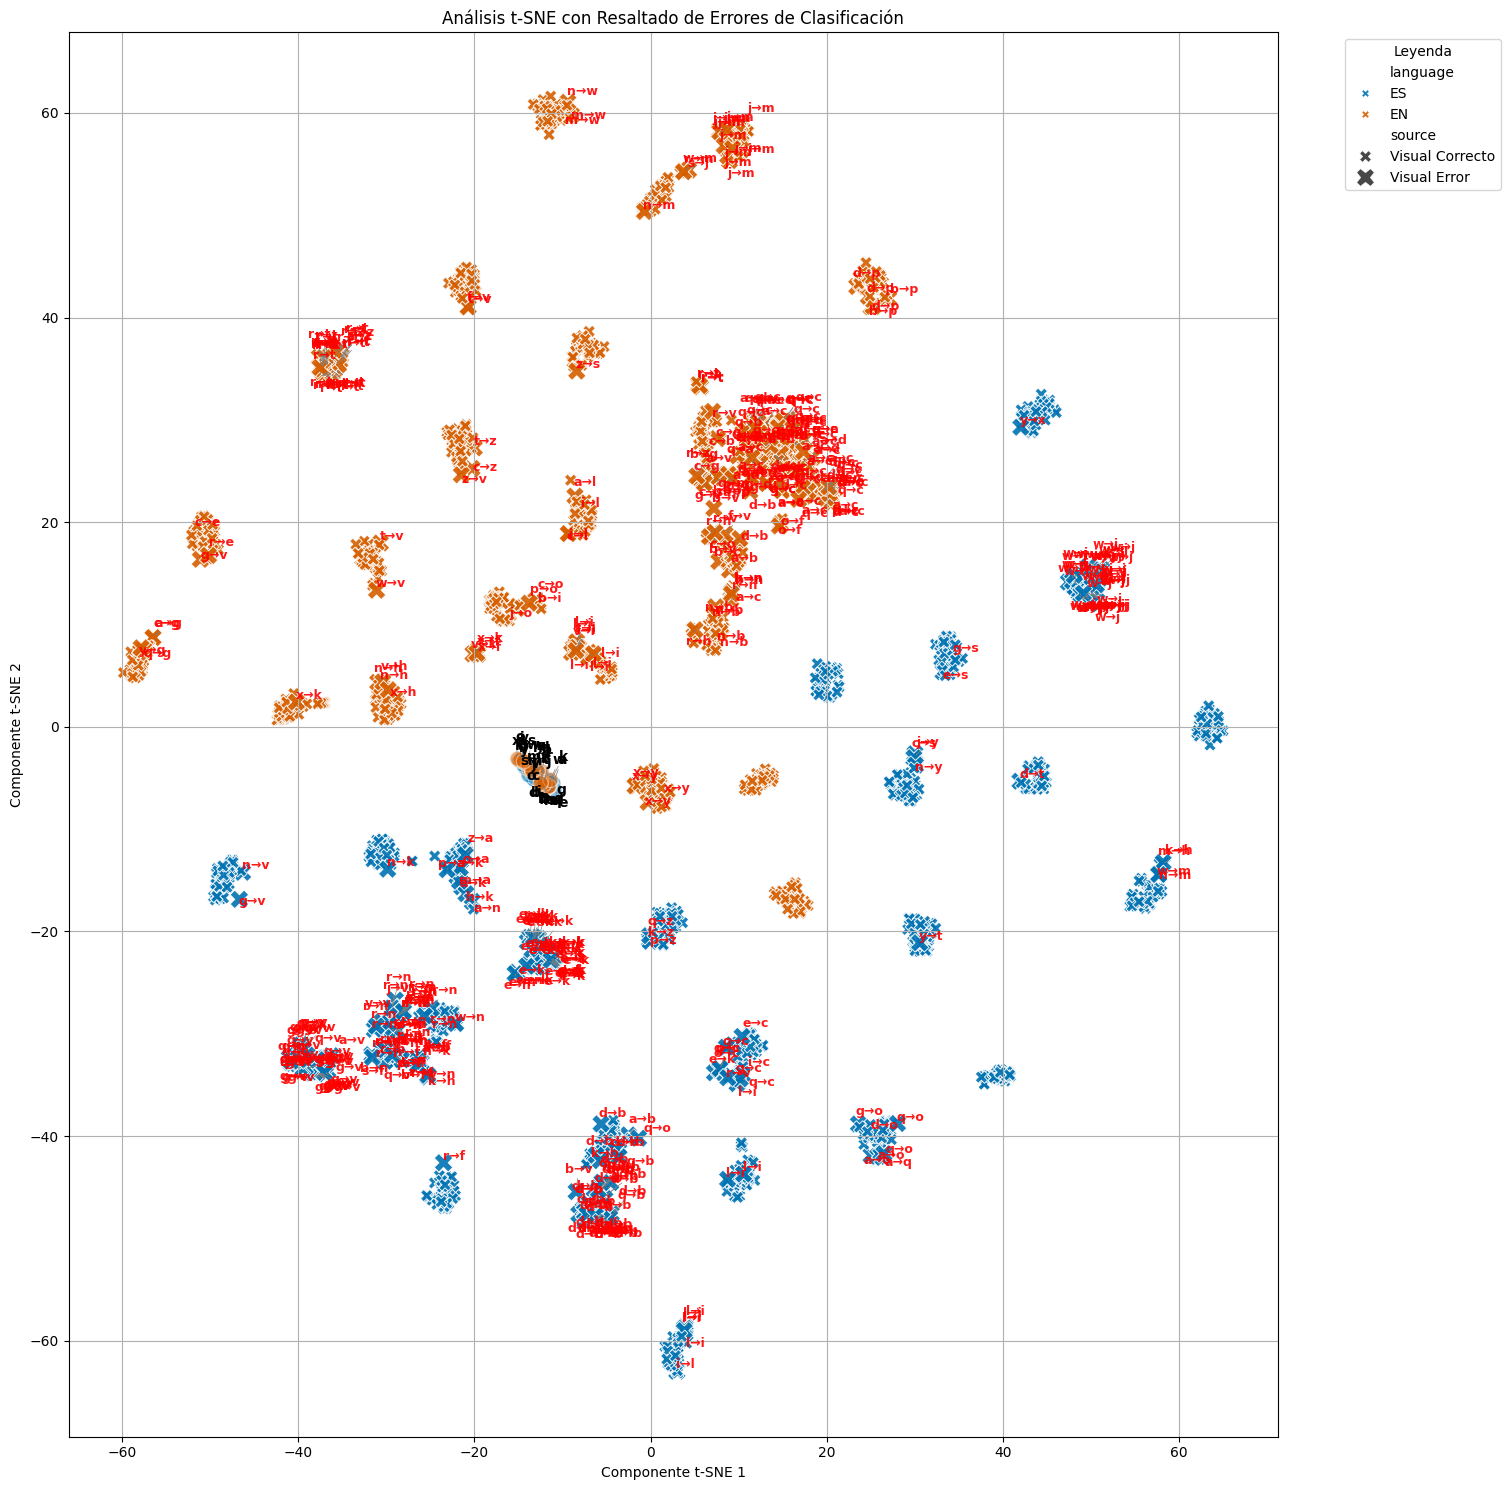

In [6]:
# --- 5.2 Comparación t-SNE con Análisis de Errores (Alta Resolución) ---
all_embeddings_avg, all_labels, all_sources, all_langs_tsne = [], [], [], []
error_data = [] # Para guardar información de los errores

print("Preparando datos para la visualización t-SNE comparativa...")
for lang in LANGUAGES:
    if lang not in results_visual:
        print(f"ADVERTENCIA: No se encontraron resultados del entrenamiento para '{lang.upper()}'.")
        continue
    
    # --- Cargar datos y modelos ---
    image_dir = project_root / f"data/02_processed/grapheme_images_resized_{IMAGE_SIZE}/{lang}"
    embedding_dir = project_root / f"data/02_processed/wav2vec2_embeddings/{lang}"
    auditory_model_path = model_dir / f"{lang}_auditory_cnn1d_comparative.pth"
    
    eval_dataset = GraphemeDataset(image_dir, embedding_dir, transform=transform_train)
    eval_loader = DataLoader(eval_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn_visual)
    
    auditory_cnn = PhonemeCNN(num_classes=len(eval_dataset.labels)).to(device)
    auditory_cnn.load_state_dict(torch.load(auditory_model_path, map_location=device))
    auditory_cnn.eval()

    visual_model = results_visual[lang]['model']
    visual_model.eval()

    # --- 1. Obtener embeddings REALES de audio ---
    real_embeddings_map = {label: np.load(embedding_dir / f"{label}.npy").mean(axis=0) for label in eval_dataset.labels}
    for label, avg_emb in real_embeddings_map.items():
        all_embeddings_avg.append(avg_emb)
        all_labels.append(label)
        all_sources.append('Audio Real')
        all_langs_tsne.append(lang.upper())

    # --- 2. Obtener embeddings PREDICHOS y clasificarlos ---
    with torch.no_grad():
        for images, targets, labels in eval_loader:
            pred_embs = visual_model(images.to(device), targets.to(device))
            outputs = auditory_cnn(pred_embs)
            _, predicted_indices = torch.max(outputs.data, 1)
            
            avg_pred_embs = pred_embs.mean(dim=1).cpu().numpy()
            
            for i, true_label in enumerate(labels):
                predicted_label = eval_dataset.labels[predicted_indices[i].item()]
                is_correct = (true_label == predicted_label)
                
                all_embeddings_avg.append(avg_pred_embs[i])
                all_labels.append(true_label)
                all_sources.append('Visual Correcto' if is_correct else 'Visual Error')
                all_langs_tsne.append(lang.upper())
                
                if not is_correct:
                    error_data.append({
                        'grapheme': f"{true_label}→{predicted_label}",
                        'language': lang.upper(),
                        'source': 'Visual Error',
                        'tsne_coords': None #Placeholder, se rellenará después
                    })

# --- Calcular t-SNE ---
if not all_embeddings_avg:
    print("\nERROR: La lista de embeddings está vacía.")
else:
    print("\nCalculando proyección t-SNE...")
    tsne = TSNE(n_components=2, perplexity=30, random_state=RANDOM_SEED, init='pca', learning_rate='auto')
    embeddings_2d = tsne.fit_transform(np.array(all_embeddings_avg))

    tsne_df = pd.DataFrame({
        'tsne-1': embeddings_2d[:, 0], 'tsne-2': embeddings_2d[:, 1],
        'grapheme': all_labels, 'language': all_langs_tsne, 'source': all_sources
    })
    
    # Rellenar las coordenadas t-SNE para los puntos de error
    # Necesitamos una forma robusta de mapear de nuevo los errores
    error_indices = tsne_df[tsne_df['source'] == 'Visual Error'].index
    error_df_mapped = tsne_df.loc[error_indices, ['tsne-1', 'tsne-2', 'grapheme', 'language', 'source']].copy()
    
    # Aquí es donde tienes que reconstruir el 'grapheme' de error para que coincida con el original
    # Esto asume que el orden de error_data y df_errors es el mismo, lo cual debería ser
    # si se construyen en el mismo bucle o de forma controlada.
    # Una forma más segura sería añadir el índice original al error_data.
    
    # Para simplificar y asumir el orden:
    for idx, (original_error_idx, row_error_df) in enumerate(error_df_mapped.iterrows()):
        error_data[idx]['tsne-1'] = row_error_df['tsne-1']
        error_data[idx]['tsne-2'] = row_error_df['tsne-2']


    # --- Graficar con resaltado de errores ---
    plt.figure(figsize=(18, 15)) # Aumenta el tamaño de la figura
    
    palette = {'ES': '#0072B2', 'EN': '#D55E00'} 
    markers = {'Audio Real': 'o', 'Visual Correcto': 'X', 'Visual Error': 'X'}
    
    size_map = {'Audio Real': 120, 'Visual Correcto': 80, 'Visual Error': 180} # Errores un poco más grandes
    
    # Dibujamos primero los puntos de Audio Real (fondo)
    df_real = tsne_df[tsne_df['source'] == 'Audio Real']
    sns.scatterplot(data=df_real, x="tsne-1", y="tsne-2", hue="language", style="source",
                    palette=palette, markers=markers, s=120, alpha=0.5, legend=False)

    # Dibujamos las predicciones visuales
    df_visual_pred = tsne_df[tsne_df['source'] != 'Audio Real']
    sns.scatterplot(data=df_visual_pred, x="tsne-1", y="tsne-2", hue="language", style="source",
                    palette=palette, markers=markers, size="source", sizes=size_map, alpha=0.9)
    
    # Etiquetamos los puntos de Audio Real
    texts = []
    df_reales_for_labels = tsne_df[tsne_df['source'] == 'Audio Real']
    for i, row in df_reales_for_labels.iterrows():
        texts.append(plt.text(row['tsne-1'], row['tsne-2'], row['grapheme'], fontsize=10, weight='bold'))
        
    # Etiquetamos los errores
    # Error_data ya tiene el formato 'grapheme': "true_label->predicted_label"
    for error_item in error_data:
        texts.append(plt.text(error_item['tsne-1'], error_item['tsne-2'], error_item['grapheme'], 
                              fontsize=9, color='red', alpha=0.9, weight='bold'))


    adjust_text(texts, arrowprops=dict(arrowstyle='->', color='gray', lw=0.5))

    plt.title('Análisis t-SNE con Resaltado de Errores de Clasificación')
    plt.xlabel('Componente t-SNE 1')
    plt.ylabel('Componente t-SNE 2')
    plt.grid(True)
    plt.legend(title='Leyenda', bbox_to_anchor=(1.05, 1), loc='upper left') # Leyenda fuera
    plt.tight_layout(rect=[0, 0, 0.85, 1]) # Ajusta el espacio para la leyenda
    
    # Guarda la figura con alta resolución (por ejemplo, 300 dpi)
    plt.savefig(figure_dir / f"comparative_{MODEL_ARCHITECTURE}_tsne_plot_with_errors.png", dpi=300) 
    plt.show()

## Paso 6: Evaluación Cuantitativa Final

Esta es la prueba de fuego. Usamos los embeddings "imaginados" por la vía visual como entrada para el clasificador auditivo experto y medimos su rendimiento de clasificación.

1.  **Matrices de Confusión**: Muestran los aciertos y errores. Una diagonal fuerte indica un buen rendimiento.
2.  **Heatmaps de Logits**: Visualizan la "confianza" del clasificador. Un patrón similar al de los datos reales (cuaderno 02) indica alta fidelidad.
3.  **Tabla de Métricas**: Calculamos Accuracy, Precisión, Recall y F1-Score para cuantificar el rendimiento.


--- Evaluación Cuantitativa para: ES ---
Dataset creado con 1250 imágenes de 25 grafemas comunes.

--- Evaluación Cuantitativa para: EN ---
Dataset creado con 1250 imágenes de 25 grafemas comunes.


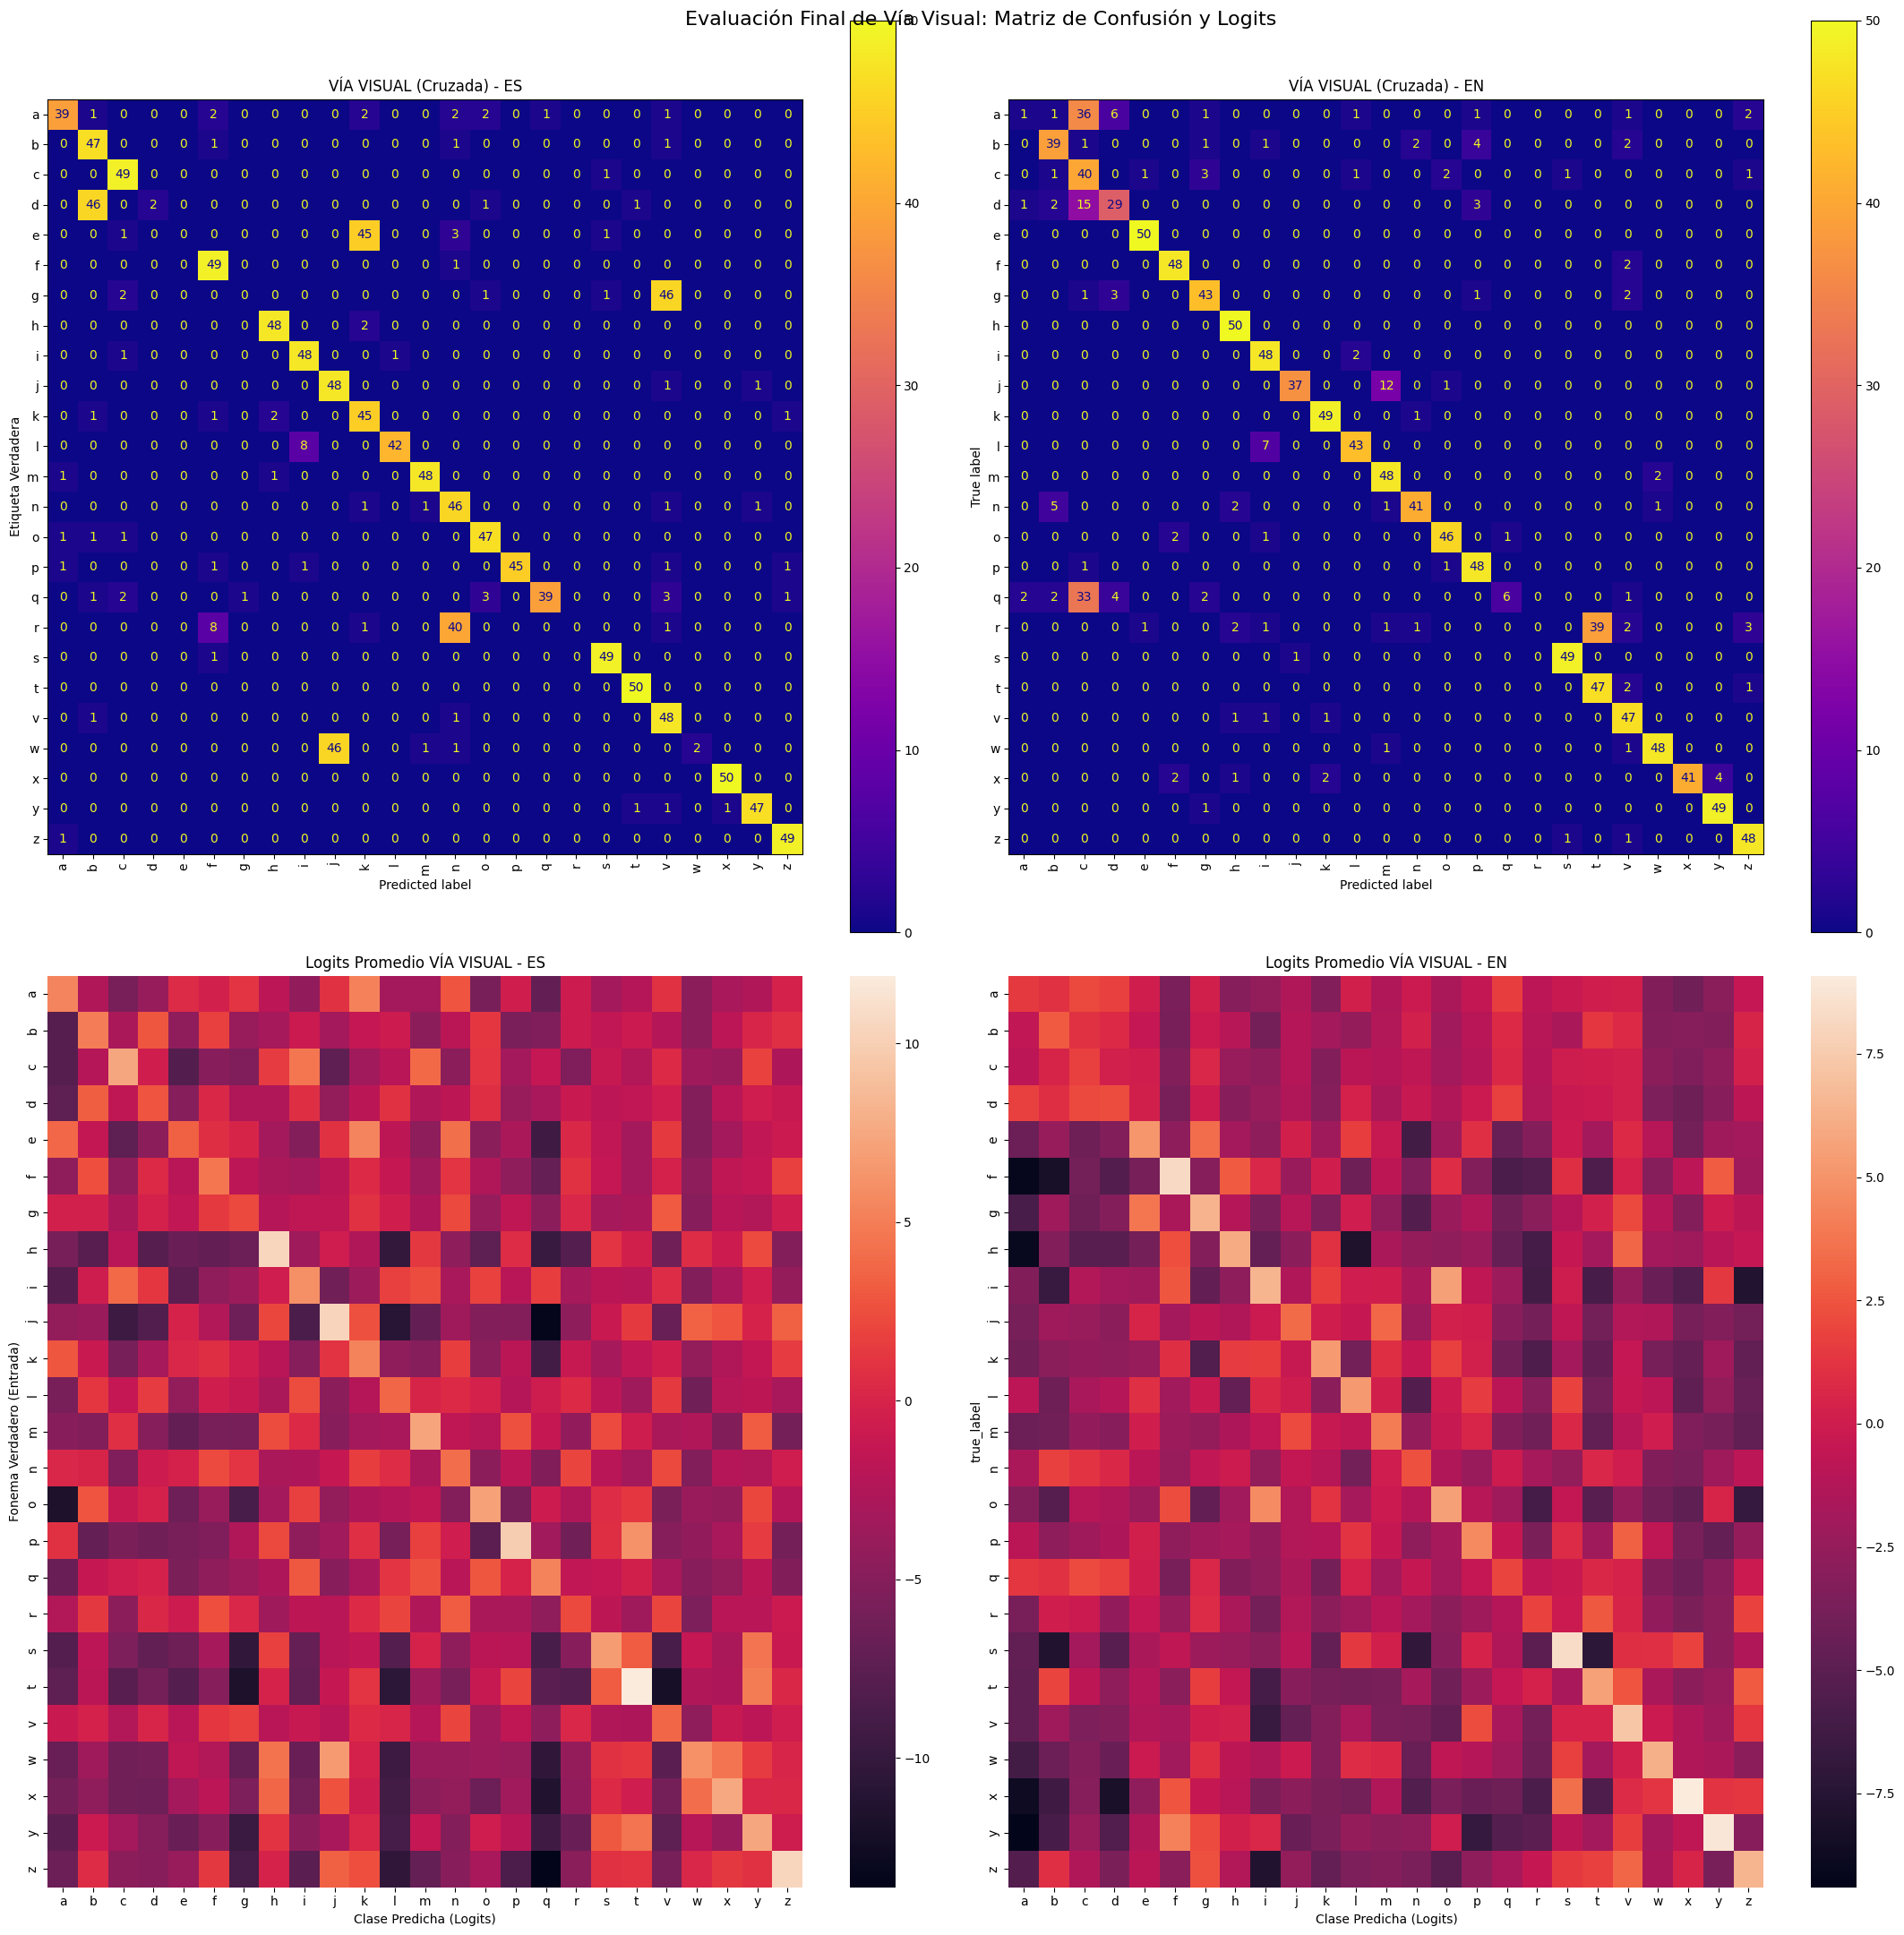

In [7]:
fig, axes = plt.subplots(2, len(LANGUAGES), figsize=(22, 22))
if len(LANGUAGES) == 1: axes = axes.reshape(2, 1)

with warnings.catch_warnings():
    warnings.simplefilter("ignore", UserWarning)
    
    for i, lang in enumerate(LANGUAGES):
        print(f"\n--- Evaluación Cuantitativa para: {lang.upper()} ---")
        if lang not in results_visual: continue
        
        image_dir = project_root / f"data/02_processed/grapheme_images_resized_{IMAGE_SIZE}/{lang}"
        embedding_dir = project_root / f"data/02_processed/wav2vec2_embeddings/{lang}"
        auditory_model_path = model_dir / f"{lang}_auditory_cnn1d_comparative.pth"
        
        eval_dataset = GraphemeDataset(image_dir, embedding_dir, transform=transform_train)
        eval_loader = DataLoader(eval_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn_visual)
        
        auditory_cnn = PhonemeCNN(num_classes=len(eval_dataset.labels)).to(device)
        auditory_cnn.load_state_dict(torch.load(auditory_model_path, map_location=device))
        auditory_cnn.eval()
        
        visual_model = results_visual[lang]['model']
        visual_model.eval()
        
        y_true_idx, y_pred_idx, all_logits_cross = [], [], []
        label_to_int_map = {lbl: i for i, lbl in enumerate(eval_dataset.labels)}
        
        with torch.no_grad():
            for images, targets, labels in eval_loader:
                predictions = visual_model(images.to(device), targets.to(device))
                outputs = auditory_cnn(predictions)
                _, predicted_indices = torch.max(outputs.data, 1)
                
                y_true_idx.extend([label_to_int_map[l] for l in labels])
                y_pred_idx.extend(predicted_indices.cpu().numpy())
                all_logits_cross.append(outputs.cpu().numpy())

        accuracy = accuracy_score(y_true_idx, y_pred_idx)
        p, r, f1, _ = precision_recall_fscore_support(y_true_idx, y_pred_idx, average='weighted', zero_division=0)
        evaluation_metrics.append({'language': lang, 'model': MODEL_ARCHITECTURE, 'accuracy': accuracy, 'precision_weighted': p, 'recall_weighted': r, 'f1_weighted': f1})
        
        # --- Gráficos ---
        ax_cm = axes[0, i]
        cm = confusion_matrix(y_true_idx, y_pred_idx, labels=range(len(eval_dataset.labels)))
        disp = ConfusionMatrixDisplay(cm, display_labels=eval_dataset.labels)
        disp.plot(ax=ax_cm, xticks_rotation='vertical', cmap='plasma') # Paleta consistente
        ax_cm.set_title(f'VÍA VISUAL (Cruzada) - {lang.upper()}')

        ax_logits = axes[1, i]
        logits_df = pd.DataFrame(np.vstack(all_logits_cross), columns=eval_dataset.labels)
        logits_df['true_label'] = [eval_dataset.labels[i] for i in y_true_idx]
        mean_logits_df = logits_df.groupby('true_label').mean().sort_index()
        mean_logits_df = mean_logits_df[sorted(mean_logits_df.columns)]
        
        sns.heatmap(mean_logits_df, xticklabels=True, yticklabels=True, ax=ax_logits, cmap='rocket') # Paleta consistente
        ax_logits.set_title(f'Logits Promedio VÍA VISUAL - {lang.upper()}')
        ax_logits.set_xlabel('Clase Predicha (Logits)');

axes[0, 0].set_ylabel('Etiqueta Verdadera'); axes[1, 0].set_ylabel('Fonema Verdadero (Entrada)')
fig.suptitle('Evaluación Final de Vía Visual: Matriz de Confusión y Logits', fontsize=16)
plt.tight_layout()
plt.savefig(figure_dir / f"comparative_{MODEL_ARCHITECTURE}_evaluation_plots.png")
plt.show()

## Paso 7: Guardado de Artefactos

Finalmente, guardamos los modelos entrenados y los informes de clasificación detallados en archivos para su uso futuro y documentación.

In [8]:
# --- Guardado de Artefactos Finales ---

# Guardar los modelos entrenados de la vía visual
for lang in LANGUAGES:
    if lang in results_visual:
        model_path = model_dir / f"{lang}_{MODEL_ARCHITECTURE}.pth"
        torch.save(results_visual[lang]['model'].state_dict(), model_path)
        print(f"Modelo para '{lang}' guardado en: {model_path}")

# Guardar el informe de clasificación final
metrics_df = pd.DataFrame(evaluation_metrics)
report_path = results_dir / f"{MODEL_ARCHITECTURE}_classification_report.csv"
metrics_df.to_csv(report_path, index=False)
print(f"\nInforme de clasificación guardado en: {report_path}")
display(metrics_df)


Modelo para 'es' guardado en: /home/daniel/Proyectos/phonological-awareness/results/trained_models/es_visual_cornetZ_lstm_perceptual.pth
Modelo para 'en' guardado en: /home/daniel/Proyectos/phonological-awareness/results/trained_models/en_visual_cornetZ_lstm_perceptual.pth

Informe de clasificación guardado en: /home/daniel/Proyectos/phonological-awareness/results/tables/visual_cornetZ_lstm_perceptual_classification_report.csv


,language,model,accuracy,precision_weighted,recall_weighted,f1_weighted
0,es,visual_cornetZ_lstm_perceptual,0.7496,0.732624,0.7496,0.689232
1,en,visual_cornetZ_lstm_perceptual,0.7960,0.784359,0.7960,0.766041
